In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio.warp import calculate_default_transform, reproject, Resampling

### Inputs

In [2]:
# General inputs
geodata= pd.read_csv('../../model/model_versions/v_7/v7_1/hds_model/GeoData.txt', sep= '\t', index_col=0)

st_mary= pd.read_csv('../../geospacial/misc/stmary_seg', header= None)

milk_shapefile= gpd.read_file('../../geospacial/shapefiles/milk_shapefile/Milk_Shapefile.shp')

managed_lakes= gpd.read_file('../../geospacial/depressions/managed_lakes.gpkg')

In [3]:
# HDS inputs
fca = pd.read_csv('./hds_outputs/spin_up_timeFCON_DD.txt', sep= '\t', skiprows=1, index_col=0)

cilv= pd.read_csv('./hds_outputs/spin_up_timeCILV_DD.txt', sep= '\t', skiprows=1, index_col=0)

In [4]:
# NCAMapper inputs
min_ca_path = './ncamapper_outputs/CA_1_0yr_1.000_mm.tif'
max_ca_path = './ncamapper_outputs/CA_3_200yr_194.000_mm.tif'

In [5]:
# full barplots 
subbasins_per_plot= 35
barplot_min_year_range= 1981
barplot_max_year_range= 2015
barplot_output_dir= './full_timeseries_boxplot/'

### Map NCAMapper CA to Shapefile

In [6]:
# Ensure both shapefiles have the same CRS (coordinate reference system)
if milk_shapefile.crs != managed_lakes.crs:
    managed_lakes = managed_lakes.to_crs(milk_shapefile.crs)

# Perform the difference operation to trim smm_shapefile by removing the parts overlapping with managed_lakes
trimmed_smm = milk_shapefile.geometry.apply(lambda geom: geom.difference(managed_lakes.unary_union))

# Create a new GeoDataFrame with the trimmed geometries
trimmed_smm_gdf = milk_shapefile.copy()
trimmed_smm_gdf['geometry'] = trimmed_smm

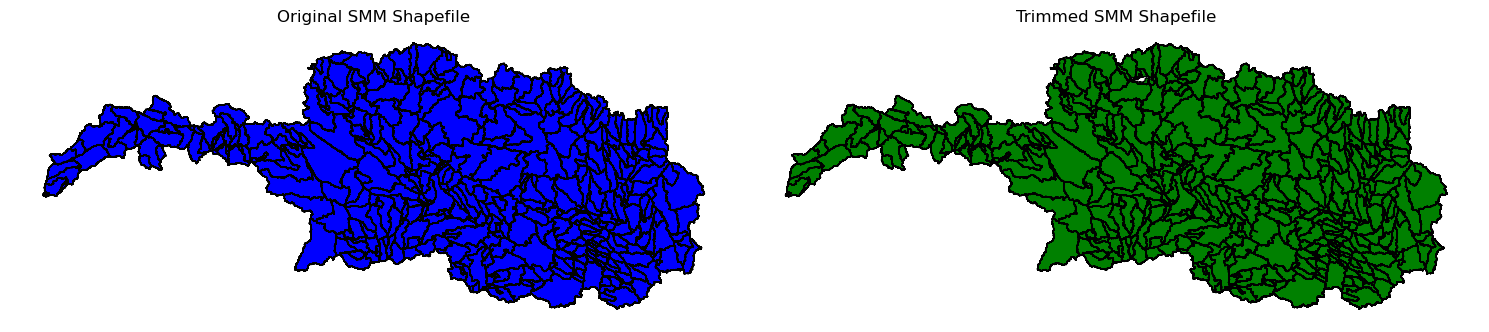

In [7]:
# Plotting to ensure trimming worked
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot the original shapefile
milk_shapefile.plot(ax=ax[0], color='blue', edgecolor='k')
ax[0].set_title('Original SMM Shapefile')
ax[0].set_axis_off()

# Plot the trimmed shapefile
trimmed_smm_gdf.plot(ax=ax[1], color='green', edgecolor='k')
ax[1].set_title('Trimmed SMM Shapefile')
ax[1].set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
def process_zonal_stats_from_gdf(raster_path, gdf):
    # Check CRS of the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        raster_epsg = raster_crs.to_string()  # Extract the EPSG code as a string
        print(f"Raster CRS EPSG: {raster_epsg}")

        # Plot the raster
        show(src)

        # Extract the transform and pixel size
        transform = src.transform
        pixel_width = transform[0]  # The pixel width is at position (0, 0)
        pixel_height = abs(transform[4])  # The pixel height is at position (1, 1)
        print(f'Pixel Height: {pixel_height}\nPixel Width: {pixel_width}')

    # Verify the initial CRS of the GeoDataFrame
    initial_epsg = gdf.crs.to_string()  # Extract the EPSG code as a string
    print(f'Initial CRS EPSG: {initial_epsg}')

    # Reproject the GeoDataFrame to match the raster's CRS
    gdf = gdf.to_crs(raster_crs)

    # Verify the reprojected CRS of the GeoDataFrame
    reprojected_epsg = gdf.crs.to_string()  # Extract the EPSG code as a string
    print(f'Reprojected CRS EPSG: {reprojected_epsg}')

    # Perform zonal statistics (mean, sum, etc.) between the reprojected GeoDataFrame and raster
    zonal_stats_results = zonal_stats(
        gdf,  # Reprojected shapefile (GeoDataFrame)
        raster_path,
        stats="count",
        geojson_out=True
    )

    # Convert the list of features into a GeoDataFrame
    zonal_stats_gdf = gpd.GeoDataFrame.from_features(zonal_stats_results)

    # Calculate NCA_Frac (NCA Fraction) using count and pixel area
    pixel_area = pixel_width * pixel_height
    zonal_stats_gdf['CA_Frac'] = (zonal_stats_gdf['count'] * pixel_area) / zonal_stats_gdf['Shape_Area']

    # Extract relevant columns ('seg_nhm' and 'NCA_Frac')
    subset_df = zonal_stats_gdf[['seg_nhm', 'CA_Frac']]

    # Set 'seg_nhm' as the index
    subset_df.set_index('seg_nhm', inplace=True)

    # Convert the index to integer
    subset_df.index = subset_df.index.astype(int)

    return subset_df

Raster CRS EPSG: EPSG:26912


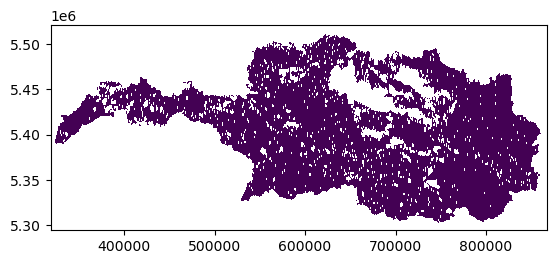

Pixel Height: 31.217319422283374
Pixel Width: 19.87737948875997
Initial CRS EPSG: EPSG:4326
Reprojected CRS EPSG: EPSG:26912


In [9]:
max_ca= process_zonal_stats_from_gdf(max_ca_path, trimmed_smm_gdf)

Raster CRS EPSG: EPSG:26912


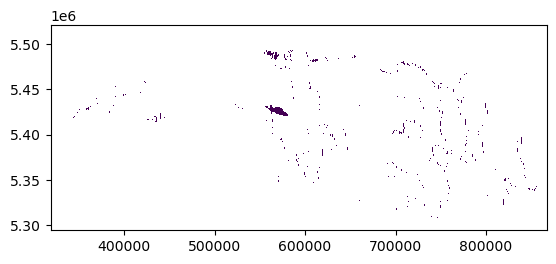

Pixel Height: 31.217319422283374
Pixel Width: 19.87737948875997
Initial CRS EPSG: EPSG:4326
Reprojected CRS EPSG: EPSG:26912


In [12]:
min_ca= process_zonal_stats_from_gdf(min_ca_path, trimmed_smm_gdf)

### Format HDS

In [13]:
# Parse the DATE column as datetime index
fca.index = pd.to_datetime(fca.index)
cilv.index = pd.to_datetime(cilv.index)
# Convert the column headers to integers
geodata.index = geodata.index.astype(int)

# Convert the column headers to integers
fca.columns = fca.columns.astype(int)
cilv.columns = cilv.columns.astype(int)

In [14]:
# Convert the values in the DataFrame to a list of integers
st_mary_list = st_mary[0].astype(int).tolist()

In [15]:
# Drop columns in `fca` that have headers found in `st_mary_list`
fca= fca.drop(columns=fca.columns[fca.columns.isin(st_mary_list)])

cilv= cilv.drop(columns=cilv.columns[cilv.columns.isin(st_mary_list)])

In [16]:
# find frac always contributing
geodata['frac_always_contributing']= 1 - geodata['icatch']

In [17]:
# find total basin area (m2)
milk_area= geodata['area'].sum()

In [18]:
# Replace any occurrence of -9999 with NaN
fca.replace(-9999, np.nan, inplace=True)
cilv.replace(-9999, np.nan, inplace=True)

In [19]:
# Filter rows where the date is between April 1st and September 30th
fca = fca[(fca.index.month >= 6) & (fca.index.month <= 9)]
cilv = cilv[(cilv.index.month >= 6) & (cilv.index.month <= 9)]

In [20]:
# Filter the DataFrame based on the year range
fca_filtered = fca[(fca.index.year >= barplot_min_year_range) & (fca.index.year <= barplot_max_year_range)].copy()
cilv_filtered = cilv[(cilv.index.year >= barplot_min_year_range) & (cilv.index.year <= barplot_max_year_range)].copy()

### icatch Validation

In [21]:
# Calculate the minimum of each column
min_con = fca_filtered.min(axis=0)

# Create a new DataFrame with the results
min_con = pd.DataFrame(min_con, columns=["Minimum_FCA"])

# Merge the 'icatch' column from df_max_per_year onto summary_df based on the index
min_con_merged = min_con.merge(geodata[['icatch']], left_index=True, right_index=True, how='left')

min_con_merged['Min_CA(1-icatch)']= 1 - min_con_merged['icatch']

min_con_merged['Difference (FCA Min -(1-icatch))']=  min_con_merged['Minimum_FCA'] - min_con_merged['Min_CA(1-icatch)']

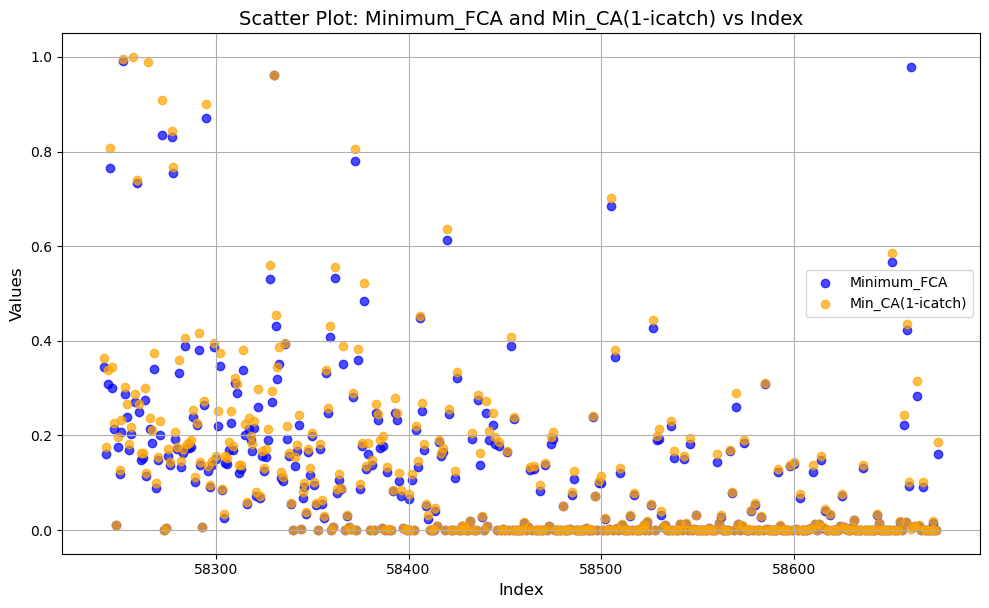

In [22]:
# Ensure the index is numeric
min_con_merged.index = pd.to_numeric(min_con_merged.index)

# Create the scatter plot
plt.figure(figsize=(10, 6.18))
plt.scatter(min_con_merged.index, min_con_merged['Minimum_FCA'], color='blue', label='Minimum_FCA', alpha=0.7)
plt.scatter(min_con_merged.index, min_con_merged['Min_CA(1-icatch)'], color='orange', label='Min_CA(1-icatch)', alpha=0.7)

# Add labels, title, legend, and grid
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Scatter Plot: Minimum_FCA and Min_CA(1-icatch) vs Index', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# Check where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA'
condition = min_con_merged['Min_CA(1-icatch)'] < min_con_merged['Minimum_FCA']

# Filter the rows where the condition is True
rows_with_smaller_values = min_con_merged[condition]

# Print results
if not rows_with_smaller_values.empty:
    print("There are rows where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA':")
else:
    print("No rows found where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA'.")

There are rows where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA':


In [24]:
rows_with_smaller_values

,Minimum_FCA,icatch,Min_CA(1-icatch),Difference (FCA Min -(1-icatch))
58661,0.979,0.998765,0.001235,0.977765
58508,0.004,0.996284,0.003716,0.000284
58557,0.001,0.999098,0.000902,0.000098
58630,0.007,0.993217,0.006783,0.000217
58449,0.002,0.998302,0.001698,0.000302
58596,0.001,0.999037,0.000963,0.000037
58613,0.012,0.988008,0.011992,0.000008
58624,0.008,0.992117,0.007883,0.000117
58487,0.001,0.999251,0.000749,0.000251
58627,0.003,0.997281,0.002719,0.000281


### Find HDS Max CA

In [25]:
# Initialize a dictionary to store max values and their corresponding dates
max_values_and_dates = {}

# Iterate over each column
for column in fca_filtered.columns:
    if fca_filtered[column].notna().any():  # Check if the column has non-NaN values
        max_value = fca_filtered[column].max()  # Maximum value
        max_date = fca_filtered[column].idxmax()  # Date of the maximum value
        max_values_and_dates[column] = {'Max Value': max_value, 'Date': max_date}
    else:
        max_values_and_dates[column] = {'Max Value': None, 'Date': None}

# Convert the dictionary into a DataFrame for better visualization
max_values_df = pd.DataFrame(max_values_and_dates).T

In [41]:
max_values_df

,Max Value,Date
58675,0.245,1983-07-11
58674,0.197,1989-08-25
58673,0.051,1983-07-10
58672,0.074,1986-09-26
58671,0.112,2002-06-11
...,...,...
58303,0.916,2011-06-17
58571,0.907,2011-06-17
58243,0.77,2011-06-18
58288,0.839,2011-06-18


In [26]:
# Ensure the 'Date' column is of datetime type
max_values_df['Date'] = pd.to_datetime(max_values_df['Date'], errors='coerce')

# Count the frequency of each date
date_counts = max_values_df['Date'].value_counts()

# Count how many dates are repeated
repeated_dates_count = (date_counts > 1).sum()
print(f"\nNumber of dates that appear more than once: {repeated_dates_count}")

# Display the dates that appear more than once
repeated_dates = date_counts[date_counts > 1]
print("\nDates that appear more than once and their frequencies:")
print(repeated_dates)

# Find the date that appears the most
most_frequent_date = max_values_df['Date'].value_counts().idxmax()
print(f"Most frequent date: {most_frequent_date}")


Number of dates that appear more than once: 40

Dates that appear more than once and their frequencies:
Date
2011-06-08    72
2011-06-07    57
1986-09-25    44
2011-06-09    32
2011-06-03    19
1986-09-30    14
2011-06-17    14
1983-07-10    11
2002-06-11    10
2011-06-04    10
2002-06-10    10
2013-06-03     9
2010-06-18     9
2011-06-18     7
2002-06-12     6
1983-07-11     6
1994-06-07     5
2014-06-17     5
2011-06-12     5
1986-09-26     5
2011-06-19     4
2014-08-24     4
2003-06-01     3
1986-09-28     3
2011-06-20     3
2014-06-18     3
1995-06-06     3
2013-06-04     3
2002-06-19     3
2002-06-13     3
1999-06-04     2
1998-06-27     2
2011-06-14     2
1986-09-27     2
2005-06-06     2
1985-09-18     2
2011-06-01     2
2009-06-06     2
2002-06-23     2
2002-07-08     2
Name: count, dtype: int64
Most frequent date: 2011-06-08 00:00:00


In [27]:
# Extract rows from fca_filtered corresponding to this date
filtered_fca_rows = fca_filtered.loc[fca_filtered.index == most_frequent_date]
filtered_cilv_rows = cilv_filtered.loc[cilv_filtered.index == most_frequent_date]

# Save the extracted rows into a new DataFrame
fca_max = filtered_fca_rows.copy()
cilv_max = filtered_cilv_rows.copy()

In [28]:
# Extract the values from the first row of each DataFrame
fca_max_values = fca_max.iloc[0].values  # Extracting the values from row 0
cilv_max_values = cilv_max.iloc[0].values  # Extracting the values from row 0

### Create Summary DataFrame

In [29]:
 #Create the summary DataFrame
summary_df = pd.DataFrame({
    'HDS_FCA_Max': fca_max_values,
    'cilv': cilv_max_values
}, index=fca_max.columns)  # Use the columns of fca_max as the index

In [30]:
# Rename 'CA_Frac' column before merging
max_ca = max_ca.rename(columns={'CA_Frac': 'NCAMapper_Max_CA_Frac'})

# Now merge the DataFrames on the index
merged_df = max_ca.merge(summary_df, left_index=True, right_index=True)

# Rename 'CA_Frac' column before merging
min_ca = min_ca.rename(columns={'CA_Frac': 'NCAMapper_Min_CA_Frac'})

# Now merge the DataFrames on the index
merged_df = min_ca.merge(merged_df, left_index=True, right_index=True)


In [31]:
# Merge the DataFrames on the index
merged_df = max_ca.merge(summary_df, left_index=True, right_index=True)

# Merge the DataFrames on the index
merged_df = min_ca.merge(merged_df, left_index=True, right_index=True)

In [32]:
merged_df = merged_df.merge(geodata[['frac_always_contributing', 'SLC_62','area','icatch']], left_index=True, right_index=True, how='left')

In [33]:
merged_df

,NCAMapper_Min_CA_Frac,NCAMapper_Max_CA_Frac,HDS_FCA_Max,cilv,frac_always_contributing,SLC_62,area,icatch
seg_nhm,,,,,,,,
58242,0.226624,0.847350,0.461,2.156,0.362830,0.053234,1.750165e+08,0.637170
58243,0.170708,0.979163,0.469,5.664,0.174972,0.081200,2.952909e+08,0.825028
58244,0.322041,0.993247,0.666,1.037,0.339217,0.089438,3.612230e+07,0.660783
58245,0.767147,1.001769,0.863,0.025,0.806693,0.051981,7.746500e+06,0.193307
58246,0.304195,0.999402,0.888,0.178,0.345393,0.131132,1.017080e+07,0.654607
...,...,...,...,...,...,...,...,...
58671,0.000000,0.750412,0.081,30.421,0.000000,0.264501,3.860121e+08,1.000000
58672,0.018485,0.183598,0.045,77.842,0.019354,0.236104,9.586554e+08,0.980646
58673,0.000076,0.010504,0.000,23.647,0.000000,0.287069,2.876408e+08,1.000000


In [34]:
# Find input precipitation required to fill depressions to this state
merged_df['P_input']= ((merged_df['cilv'] * 10**6) /(merged_df['area']*merged_df['icatch'])) * 1000 # convert m to mm

mean_P_depth= merged_df['P_input'].mean()
median_P_depth= merged_df['P_input'].median()
max_P_depth= merged_df['P_input'].max()

In [35]:
mean_P_depth

22.376655313252073

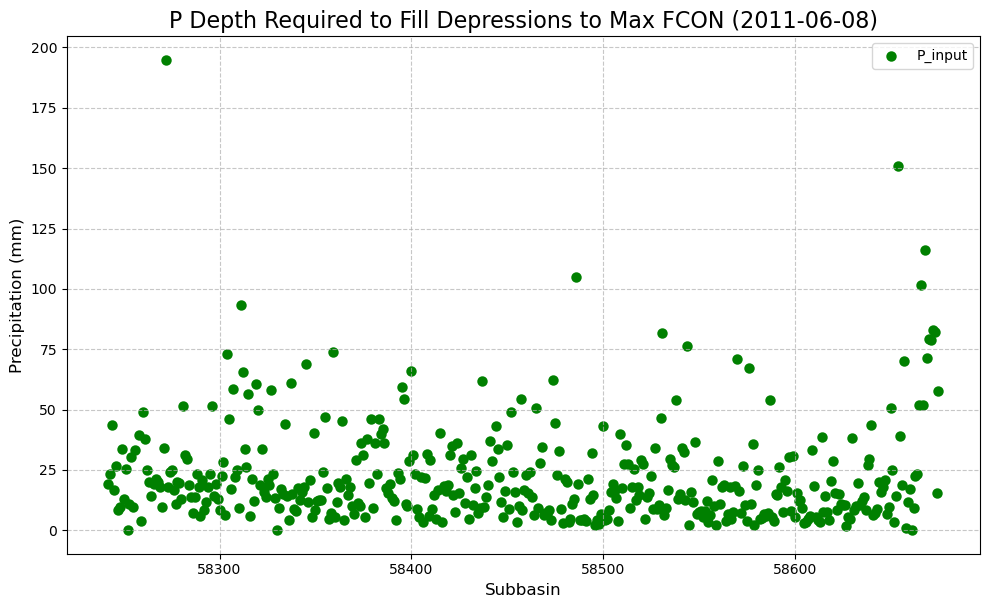

In [36]:
plt.figure(figsize=(10, 6.18))
plt.scatter(merged_df.index, merged_df['P_input'], label='P_input', color='green', linewidth=1.5)
plt.title('P Depth Required to Fill Depressions to Max FCON (2011-06-08)', fontsize=16)
plt.xlabel('Subbasin', fontsize=12)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Drop rows where 'Max_Frac_hds' is 
non_zero_ca = merged_df[merged_df['HDS_FCA_Max'] != 0]

In [38]:
non_zero_ca

,NCAMapper_Min_CA_Frac,NCAMapper_Max_CA_Frac,HDS_FCA_Max,cilv,frac_always_contributing,SLC_62,area,icatch,P_input
seg_nhm,,,,,,,,,
58242,0.226624,0.847350,0.461,2.156,0.362830,0.053234,1.750165e+08,0.637170,19.333685
58243,0.170708,0.979163,0.469,5.664,0.174972,0.081200,2.952909e+08,0.825028,23.249012
58244,0.322041,0.993247,0.666,1.037,0.339217,0.089438,3.612230e+07,0.660783,43.445494
58245,0.767147,1.001769,0.863,0.025,0.806693,0.051981,7.746500e+06,0.193307,16.694997
58246,0.304195,0.999402,0.888,0.178,0.345393,0.131132,1.017080e+07,0.654607,26.735261
...,...,...,...,...,...,...,...,...,...
58667,0.101916,0.854961,0.091,18.187,0.101852,0.111421,3.902702e+08,0.898148,51.885725
58668,0.000000,0.000373,0.034,11.201,0.000000,0.338785,9.638750e+07,1.000000,116.208014
58671,0.000000,0.750412,0.081,30.421,0.000000,0.264501,3.860121e+08,1.000000,78.808410


### Plot CA Comparison

KeyError: 'FCA_Max'

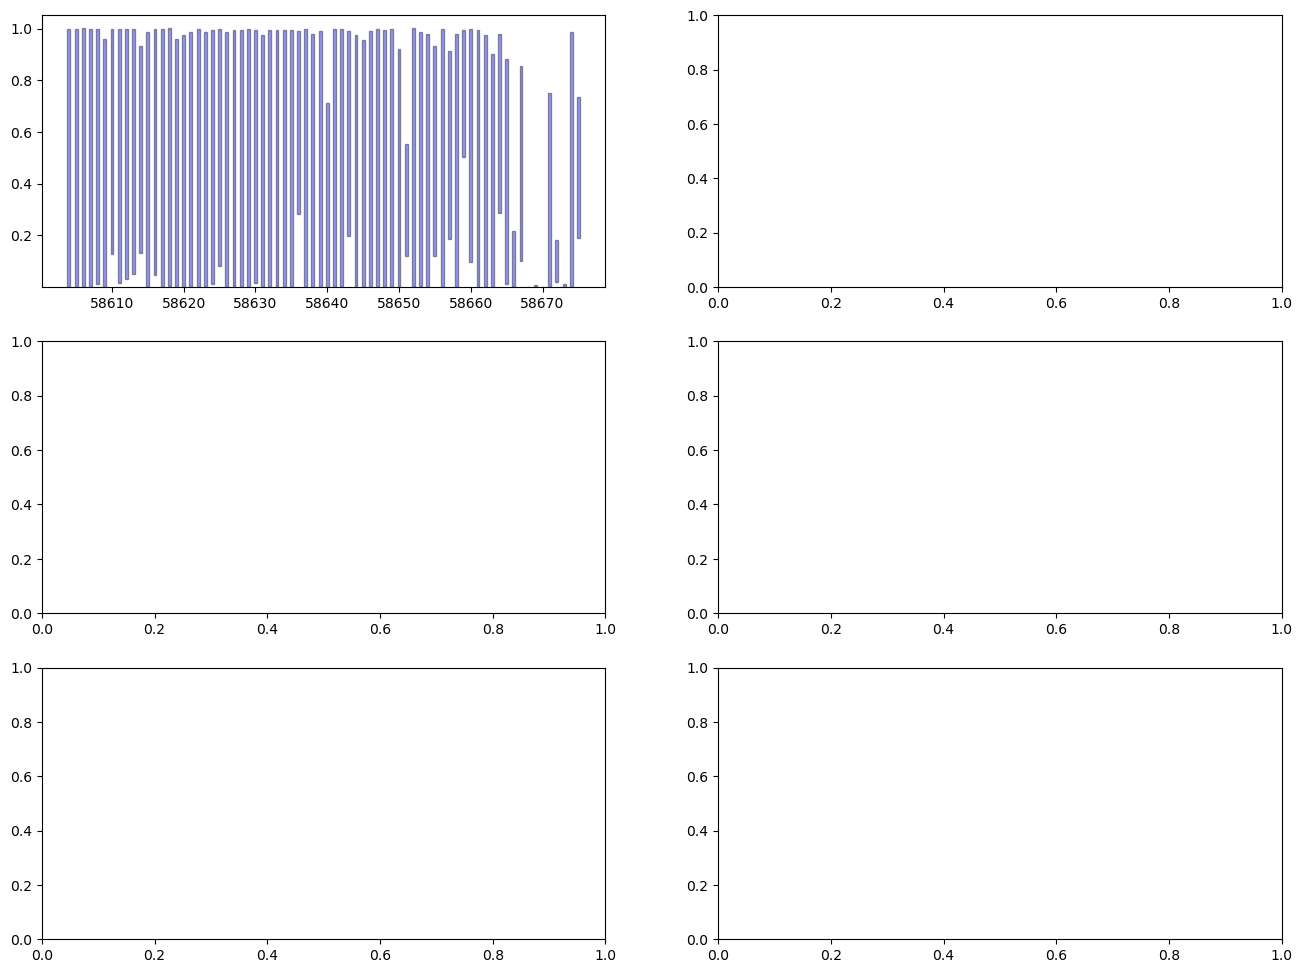

In [40]:
# Sort the DataFrame by index in descending order
df_sorted = merged_df.sort_index(ascending=False)

# Define the number of subplots
num_subplots = 6

# Determine the number of rows per group dynamically
num_rows_per_group = len(df_sorted) // num_subplots

# Define colors and transparency for the bars
bar_colors = {'NCAMapper': 'blue', 'HDS CA': 'red'}
alpha_value = 0.4  # Adjust the transparency (0 is fully transparent, 1 is fully opaque)

# Create a figure with 6 subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))  # 3 rows, 2 columns of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

# Loop through each group and create plots
for group in range(num_subplots):
    start_row = group * num_rows_per_group
    end_row = min((group + 1) * num_rows_per_group, len(df_sorted))
    
    # Select rows for the current group
    group_df = df_sorted.iloc[start_row:end_row]

    # Get the current axis
    ax = axes[group]

    # First and last index values in the group for the title
    first_index = group_df.index[0]
    last_index = group_df.index[-1]

    # Bar for NCAMapper range
    ax.bar(group_df.index, 
           group_df['NCAMapper_Max_CA_Frac'] - group_df['NCAMapper_Min_CA_Frac'], 
           width=0.4, 
           bottom=group_df['NCAMapper_Min_CA_Frac'], 
           color=bar_colors['NCAMapper'], 
           alpha=alpha_value, 
           label='NCAMapper Range',
           edgecolor='black')

    # Bar for HDS CA range
    ax.bar(group_df.index, 
           group_df['HDS_FCA_Max'] - group_df['HDS_FCA_Min'], 
           width=0.4, 
           bottom=group_df['HDS_FCA_Min'], 
           color=bar_colors['HDS CA'], 
           alpha=alpha_value, 
           label='HDS Range',
           edgecolor='black')

    # Title for each subplot
    ax.set_title(f'Subbasins {first_index} to {last_index}')

    # Set x-axis ticks to only show every third tick
    ax.set_xticks(group_df.index[::3])  # Show every 3rd tick
    ax.set_xticklabels(group_df.index[::3], rotation=45)  # Set tick labels for every 3rd tick

    # Enable minor ticks
    ax.minorticks_on()

    # Set limits for the x-axis
    ax.set_xlim(group_df.index.min() - 1, group_df.index.max() + 1)

    # Set axes labels for each subplot
    ax.set_xlabel('Subbasin ID')  # X-axis label for each subplot
    ax.set_ylabel('CA Fraction (-)')  # Y-axis label for each subplot

    ax.legend(loc='lower right')

# Adjust layout and save the figure
plt.tight_layout()
plot_filename = os.path.join(barplot_output_dir, 'subbasin_bar_plots.png')
plt.savefig(plot_filename)
plt.show()

In [ ]:
# Initialize counters
overlap_count = 0
larger_range_count = 0

# Iterate over each subbasin in the sorted DataFrame
for index, row in df_sorted.iterrows():
    # Define the ranges for NCAMapper
    ca_max = row['NCAMapper_CA_6_100yr_86_mm_Min']
    ca_min = row['NCAMapper_CA_1_2yr_38_mm_Max']

    # Define the ranges for HDS CA
    hds_min = row['Minimum Contributing Area Fraction']
    hds_max = row['Maximum Contributing Area Fraction']

    # Check for overlap
    if ca_min <= hds_max and hds_min <= ca_max:
        overlap_count += 1

    # Check if HDS CA has a larger range than NCAMapper CA
    if (hds_max - hds_min) > (ca_max - ca_min):
        larger_range_count += 1

# Calculate percentages
overlap_percentage = (overlap_count / 433) * 100  # Assuming there are 433 subbasins
larger_range_percentage = (larger_range_count / 433) * 100

# Print results
print(f'Number of subbasins where shaded areas overlap: {overlap_count}')
print(f'% of subbasins where shaded areas overlap: {overlap_percentage:.2f}%')
print(f'Number of subbasins where HDS CA has a larger range than NCAMapper CA: {larger_range_count}')
print(f'% of subbasins where HDS CA has a larger range than NCAMapper CA: {larger_range_percentage:.2f}%')
